# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [3]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip3 install chart-studio

Defaulting to user installation because normal site-packages is not writeable


In [14]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

In [65]:
import pandas as pd
data = pd.read_csv("../datasets/TempAndre.csv",index_col=0)
data.describe()

,_value
count,449.000000
mean,27.829988
std,0.551873
min,23.327273
25%,27.513846
50%,27.979592
75%,28.279687
max,28.500000


In [66]:
data.index = pd.to_datetime(data.index)

In [67]:
data.head()
print(data.shape[0])

449


In [68]:
data.columns = ['value']

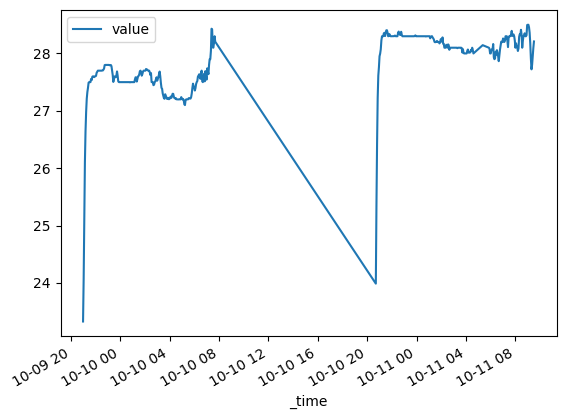

In [70]:
plot_cols = ['value']
plot_features = data[plot_cols]
plot_features.index = data.index
_ = plot_features.plot(subplots=True)


In [71]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(data.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.428
ARIMA(0, 0, 1) RMSE=0.252
ARIMA(0, 0, 2) RMSE=0.183
ARIMA(0, 1, 0) RMSE=0.069
ARIMA(0, 1, 1) RMSE=0.069
ARIMA(0, 1, 2) RMSE=0.069
ARIMA(0, 2, 0) RMSE=0.089
ARIMA(0, 2, 1) RMSE=0.070
ARIMA(0, 2, 2) RMSE=0.070
ARIMA(1, 0, 0) RMSE=0.072
ARIMA(1, 0, 1) RMSE=0.072
ARIMA(1, 0, 2) RMSE=0.072
ARIMA(1, 1, 0) RMSE=0.069
ARIMA(1, 1, 1) RMSE=0.069
ARIMA(1, 1, 2) RMSE=0.067
ARIMA(1, 2, 0) RMSE=0.082
ARIMA(1, 2, 1) RMSE=0.070
ARIMA(1, 2, 2) RMSE=0.070
ARIMA(2, 0, 0) RMSE=0.072
ARIMA(2, 0, 1) RMSE=0.072
ARIMA(2, 0, 2) RMSE=0.071
ARIMA(2, 1, 0) RMSE=0.069
ARIMA(2, 1, 1) RMSE=0.067
ARIMA(2, 1, 2) RMSE=0.067
ARIMA(2, 2, 0) RMSE=0.080
ARIMA(2, 2, 1) RMSE=0.069
ARIMA(2, 2, 2) RMSE=0.069
Best ARIMA(2, 1, 1) RMSE=0.067


In [100]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(data.values, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=272.947, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=178.589, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=273.990, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=137.226, Time=0.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.47 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=135.325, Time=0.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=176.932, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=137.201, Time=0.37 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=130.924, Time=1.13 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=168.140, Time=

In [235]:

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
	return datetime.fromisoformat(x[:-1]).astimezone(timezone.utc).strftime('%Y-%m-%d %H:%M:%S')

series = pd.read_csv("../datasets/TempAndre.csv",index_col=0)

# split into train and test sets
nrows = (len(series.values))
splitPoint = int (nrows * 0.60)
train = series['Temperature'] [:splitPoint]
test = series ['Temperature'] [splitPoint:]

history = [x for x in train]
predictions = list()
l = list()
for x in history:
	l.append(x)

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	l.append(yhat)
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


future_forecast1 = pd.DataFrame(predictions,index = test.index ,columns = ['Predicted values'])
future_forecast2 = pd.DataFrame(l,index = series.index,  columns = ['Predicted values'])

colors = ["blue","red"]
pd.concat([future_forecast1,test],axis=1).iplot(color = colors)
pd.concat([future_forecast2,train],axis=1).iplot(color = colors)

predicted=28.300598, expected=28.300000
predicted=28.300501, expected=28.300000
predicted=28.300420, expected=28.300000
predicted=28.300352, expected=28.300000
predicted=28.300294, expected=28.300000
predicted=28.300247, expected=28.300000
predicted=28.300207, expected=28.300000
predicted=28.300174, expected=28.300000
predicted=28.300145, expected=28.300000
predicted=28.300122, expected=28.304918
predicted=28.304971, expected=28.315385
predicted=28.314907, expected=28.300000
predicted=28.298868, expected=28.300000
predicted=28.300355, expected=28.300000
predicted=28.300297, expected=28.300000
predicted=28.300249, expected=28.300000
predicted=28.300209, expected=28.300000
predicted=28.300175, expected=28.300000
predicted=28.300147, expected=28.300000
predicted=28.300123, expected=28.300000
predicted=28.300103, expected=28.300000
predicted=28.300086, expected=28.300000
predicted=28.300073, expected=28.300000
predicted=28.300061, expected=28.300000
predicted=28.300051, expected=28.300000
